<a href="https://colab.research.google.com/github/SriKrishnaMishra/Machine-Learning/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data-Set

https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho



### **Helps confirm expected relationships in the dataset:**

Newer cars (Age low) → higher selling price.

Higher Present_Price → higher selling price.

Manual vs. Automatic (Transmission) → price differences.


In [23]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline


In [10]:
df = pd.read_csv('/content/vehicle-dataset-from-cardekho/car data.csv')   # <- update path if needed
print('Rows,Cols:', df.shape)
display(df.head())

Rows,Cols: (301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None


In [12]:
print('Missing values per column:\n', df.isna().sum())
print('Target (Selling_Price) summary:')
print(df['Selling_Price'].describe())

Missing values per column:
 Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64
Target (Selling_Price) summary:
count    301.000000
mean       4.661296
std        5.082812
min        0.100000
25%        0.900000
50%        3.600000
75%        6.000000
max       35.000000
Name: Selling_Price, dtype: float64


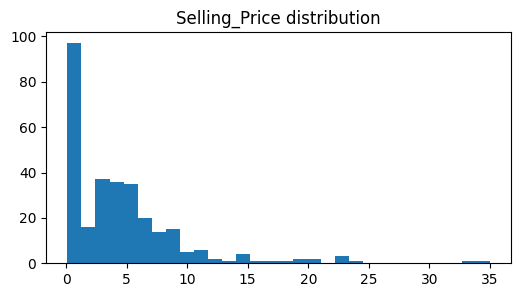

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.title('Selling_Price distribution')
plt.hist(df['Selling_Price'], bins=30)
plt.show()

In [16]:
current_year = pd.Timestamp.now().year
df['Age'] = current_year - df['Year']
df = df.drop(columns=['Year', 'Car_Name'])


In [17]:
target = 'Selling_Price'
num_features = ['Present_Price', 'Kms_Driven', 'Owner', 'Age']
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']  # keep Transmission as categorical

X = df.drop(columns=[target])
y = df[target]


In [20]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:

from sklearn.linear_model import LinearRegression
##cross validation
from sklearn.model_selection import cross_val_score

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

pipe = Pipeline([
    ('preproc', preprocessor),
    ('reg', LinearRegression())
])

In [31]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Kms_Driven', 'Owner',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission'])])),
                ('reg', LinearRegression())])

In [35]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = pipe.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Test MAE:', mean_absolute_error(y_test, y_pred))
print('Test R2:', r2_score(y_test, y_pred))


Test RMSE: 1.8651552135513827
Test MAE: 1.2162256821297066
Test R2: 0.8489813024899066


In [36]:
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)
print('CV RMSE mean:', cv_rmse.mean(), 'std:', cv_rmse.std())

CV RMSE mean: 2.0409556885645768 std: 0.9285164711496718


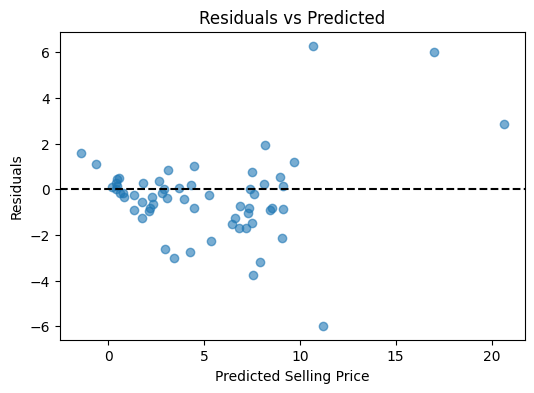

In [37]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

In [38]:
feature_names = list(num_features)


In [40]:
preproc = pipe.named_steps['preproc']
ohe = preproc.named_transformers_['cat'].named_steps['ohe']
try:
    cat_names = list(ohe.get_feature_names_out(cat_features))
except Exception:
    # fallback for older scikit-learn
    cat_names = list(ohe.get_feature_names(cat_features))

feature_names += cat_names

coefs = pipe.named_steps['reg'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print('\nTop coefficients by absolute value:')
display(coef_df.head(12))


Top coefficients by absolute value:


,feature,coef,abs_coef
0,Present_Price,3.850784,3.850784
1,Fuel_Type_Diesel,1.442694,1.442694
2,Fuel_Type_CNG,-1.090579,1.090579
3,Age,-1.018523,1.018523
4,Transmission_Manual,-0.819511,0.819511
5,Transmission_Automatic,0.819511,0.819511
6,Seller_Type_Dealer,0.595296,0.595296
7,Seller_Type_Individual,-0.595296,0.595296
8,Fuel_Type_Petrol,-0.352115,0.352115
9,Kms_Driven,-0.257158,0.257158


In [41]:
def interpret_keyword(k):
    rows = coef_df[coef_df['feature'].str.contains(k, case=False)]
    if rows.empty:
        print(f'No feature found matching: "{k}"\n')
        return
    for _, r in rows.iterrows():
        sign = 'increase' if r['coef'] > 0 else 'decrease'
        print(f"- {r['feature']}: coef = {r['coef']:.4f}  --> {sign} selling price by {abs(r['coef']):.4f} (units = target units).")

print('\nInterpretations (requested):')
interpret_keyword('Present_Price')
interpret_keyword('Age')
interpret_keyword('Kms_Driven')
interpret_keyword('Owner')
interpret_keyword('Transmission')   # shows Automatic vs Manual as separate OHE features
interpret_keyword('Fuel_Type')


Interpretations (requested):
- Present_Price: coef = 3.8508  --> increase selling price by 3.8508 (units = target units).
- Age: coef = -1.0185  --> decrease selling price by 1.0185 (units = target units).
- Kms_Driven: coef = -0.2572  --> decrease selling price by 0.2572 (units = target units).
- Owner: coef = -0.2433  --> decrease selling price by 0.2433 (units = target units).
- Transmission_Manual: coef = -0.8195  --> decrease selling price by 0.8195 (units = target units).
- Transmission_Automatic: coef = 0.8195  --> increase selling price by 0.8195 (units = target units).
- Fuel_Type_Diesel: coef = 1.4427  --> increase selling price by 1.4427 (units = target units).
- Fuel_Type_CNG: coef = -1.0906  --> decrease selling price by 1.0906 (units = target units).
- Fuel_Type_Petrol: coef = -0.3521  --> decrease selling price by 0.3521 (units = target units).


In [44]:
print('\nTop positive drivers:')
display(coef_df[coef_df['coef'] > 0].head(5))
print('\nTop negative drivers:')
display(coef_df[coef_df['coef'] < 0].head(5))


Top positive drivers:


,feature,coef,abs_coef
0,Present_Price,3.850784,3.850784
1,Fuel_Type_Diesel,1.442694,1.442694
5,Transmission_Automatic,0.819511,0.819511
6,Seller_Type_Dealer,0.595296,0.595296



Top negative drivers:


,feature,coef,abs_coef
2,Fuel_Type_CNG,-1.090579,1.090579
3,Age,-1.018523,1.018523
4,Transmission_Manual,-0.819511,0.819511
7,Seller_Type_Individual,-0.595296,0.595296
8,Fuel_Type_Petrol,-0.352115,0.352115


In [46]:
import joblib

joblib.dump(pipe, 'linear_regression_car_price_pipeline.joblib')
print('Saved pipeline to linear_regression_car_price_pipeline.joblib')

Saved pipeline to linear_regression_car_price_pipeline.joblib
